In [57]:
import matplotlib.pyplot as plt
import numpy
import sqlite3
import os
import matplotlib.ticker as ticker
from sklearn.metrics import r2_score 

curs = sqlite3.connect(os.getcwd() + '/../655.sqlite').cursor()

plt.style.use('ggplot')

CF_COUNTRIES = [('ALGERIA', 250000), ('AUSTRALIA', 10000000), ('BAHRAIN', 50000),
                ('BRUNEI', 250000), ('CANADA', 250000), ('GERMANY', 100000), 
                ('IRELAND', 5000000), ('ITALY', 100000), ('JAMAICA', 50000), 
                ('KUWAIT', 5000000), ('MOROCCO', 2000000), ('NETHERLANDS', 5000000), 
                ('NORWAY', 10000000), ('OMAN', 1000000), ('QATAR', 1000000),
                ('SAUDI ARABIA', 10000000), ('TAIWAN', 500000), ('THAILAND', 250000), 
                ('UNITED ARAB EMIRATES', 1000000), ('UNITED KINGDOM', 1000000)]

In [2]:
def get_sums(curs):
    sums_0608 = curs.execute('''SELECT country, sum(services+articles)
                                 FROM sales 
                               WHERE year >= 2006 AND year <= 2008
                               GROUP BY country''').fetchall()
    sums_1012 = curs.execute('''SELECT country, sum(services+articles)
                                 FROM sales
                               WHERE year >= 2010 and YEAR <= 2012
                               GROUP BY country''').fetchall()
    return sums_0608, sums_1012

def get_diffs(curs):
    sums_0608, sums_1012 = get_sums(curs)
    
    # Calc changes
    changes = list()
    for earlier in sums_0608:
        for later in sums_1012:
            if earlier[0] == later[0]:
                changes += [(earlier[0], later[1]-earlier[1])]
                break
        else:
            # No further sales for this country
            changes += [(earlier[0], 0-earlier[1])]
    
    changes.sort(key=(lambda item: item[1]))
    return changes

def get_perc_diffs(curs):
    sums_0608, sums_1012 = get_sums(curs)
    
    # Calc percent changes
    changes = list()
    for earlier in sums_0608:
        if earlier[1] >= 10000000:
            for later in sums_1012:
                if earlier[0] == later[0]:
                    changes += [(earlier[0], ((later[1]-earlier[1]) / earlier[1]) * 100)]
                    break
            else:
                # No further sales for this country
                changes += [(earlier[0], -100)]
            
    changes.sort(key=(lambda item: item[1]))
    return changes

In [3]:
def change_graph(curs, mode='percent'):
    assert mode in ('percent', 'dollars')
    if mode == 'dollars':
        changes = get_diffs(curs)
    elif mode == 'percent':
        changes = get_perc_diffs(curs)
    for yy in numpy.arange(len(changes)):
        if changes[yy][0] in [i[0] for i in CF_COUNTRIES]:
            plt.bar(yy, changes[yy][1], color='orangered')
        else:
            plt.bar(yy, changes[yy][1])
    plt.xticks([])
    plt.show()

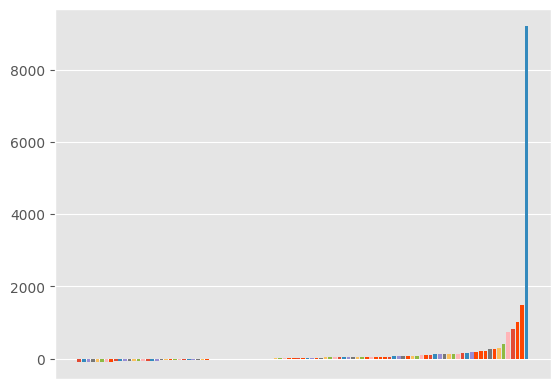

In [4]:
change_graph(curs)

In [25]:
def change_scatter(curs, fits=True, divider=True, various=True):
    sums_0608, sums_1012 = get_sums(curs)
    
    # Match old and new value
    changes = list()
    cf_changes = list()
    for earlier in sums_0608:
        if various or earlier[0] not in ('VARIOUS'):
            for later in sums_1012:
                if earlier[0] == later[0]:
                    if earlier[0] in [i[0] for i in CF_COUNTRIES]:
                        cf_changes += [(earlier[0], earlier[1], later[1])]
                    else:
                        changes += [(earlier[0], earlier[1], later[1])]
                    break
            else:
                # No further sales for this country
                changes += [(earlier[0], earlier[1], 0)]
    x_changes = [i[1] for i in changes]
    y_changes = [i[2] for i in changes]
    x_cf_changes = [i[1] for i in cf_changes]
    y_cf_changes = [i[2] for i in cf_changes]
    max_x = max(x_changes+x_cf_changes)
    min_x = min(x_changes+x_cf_changes)
    max_y = max(y_changes+y_cf_changes)
    min_y = min(y_changes+y_cf_changes)
    def aspect(width, height, out_width=5):
        out_height = out_width*(height/width)
        return out_width, out_height
    fig = plt.figure(figsize=aspect(max_x-min_x, max_y-min_y))
    if fits:
        reg = numpy.polyfit(x_changes, y_changes, 1)
        p = numpy.poly1d(reg)
        plt.plot([min_x, max_x], p([min_x, max_x]), color='dodgerblue', linewidth=1, zorder=2,
                   label='Non-CF Donors')
        reg = numpy.polyfit(x_cf_changes, y_cf_changes, 1)
        p = numpy.poly1d(reg)
        plt.plot([min_x, max_x], p([min_x, max_x]), color='darkorange', linewidth=1, zorder=2,
                   label='CF Donors')
        reg = numpy.polyfit(x_cf_changes+x_changes, y_cf_changes+y_changes, 1)
        p = numpy.poly1d(reg)
        plt.plot([min_x, max_x], p([min_x, max_x]), color='grey', alpha=0.8, linewidth=1, zorder=2,
                   label='All')
    plt.scatter(x_changes, y_changes, color='dodgerblue', zorder=3)
    plt.scatter(x_cf_changes, y_cf_changes, color='darkorange', zorder=3)
    axes = plt.gca()
    axes.set_aspect('equal')
    if divider:
        plt.plot([0, max_x], [0, max_x], color='grey', alpha=0.8, linewidth=1, zorder=1)
    axes.set_xlim([0, max_x+10**9])
    axes.set_ylim([min_y, max_y+10**9])
    def billions(x, pos):
        'The two args are the value and tick position'
        return '$%1.0f' % (x*1e-10)
    axes.xaxis.set_major_formatter( ticker.FuncFormatter(billions) )
    axes.xaxis.set_minor_formatter( ticker.FuncFormatter(billions) )
    axes.yaxis.set_major_formatter( ticker.FuncFormatter(billions) )
    axes.yaxis.set_minor_formatter( ticker.FuncFormatter(billions) )
    plt.title('Approved Arms Sales\n(billions of dollars)')
    plt.xlabel('2006-2008')
    plt.ylabel('2010-2012')
    plt.legend(loc='upper left')
    plt.tight_layout()
    #print(max_x, min_x, max_y, min_y)
    plt.show()
    #pylab.savefig('trendscatter8.png', bbox_inches='tight', facecolor='white', orientation='portrait')

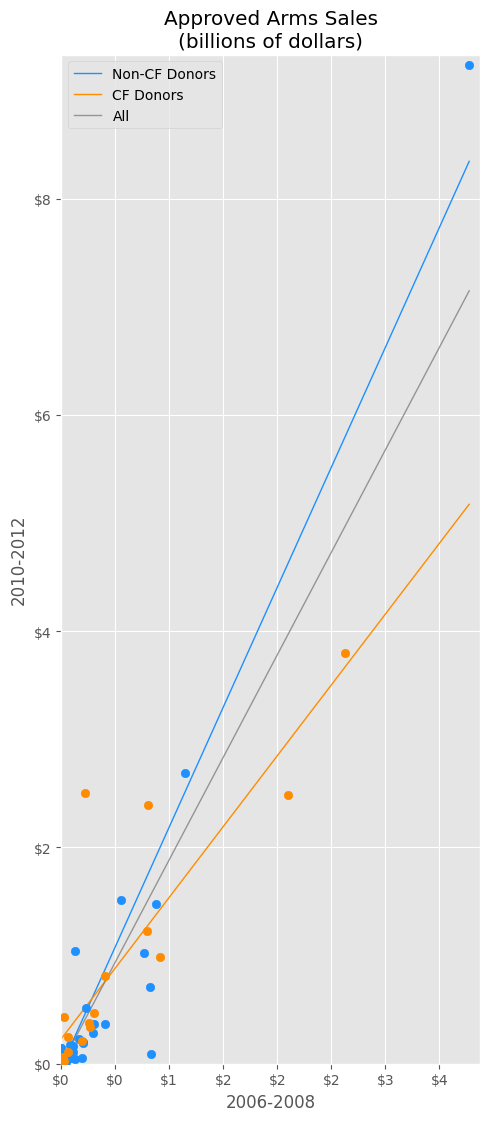

In [26]:
change_scatter(curs, fits=True, divider=False, various=False)

In [92]:
def payoff_graph(curs, fit=True):
    changes = get_perc_diffs(curs)
    # Match changes to Clinton Foundation donations
    cf_match = list()
    for country in changes:
        for cf_country in CF_COUNTRIES:
            if country[0] == cf_country[0]:
                cf_match += [(country[0], country[1], cf_country[1])]
                break
    plt.scatter([i[2] for i in cf_match], [i[1] for i in cf_match])
    if fit:
        x_values = [i[2] for i in cf_match]
        y_values = [i[1] for i in cf_match]

        reg = numpy.polyfit(x_values, y_values, 1)
        p = numpy.poly1d(reg)
        R2 = r2_score(y_values, p(x_values))
        print(R2)
        plt.plot(x_values, p(x_values))
    def millions(x, pos):
        'The two args are the value and tick position'
        return '$%1.0f' % (x*1e-6)
    axes = plt.gca()
    axes.xaxis.set_major_formatter( ticker.FuncFormatter(millions) )
    axes.xaxis.set_minor_formatter( ticker.FuncFormatter(millions) )
    axes.text(8000000, 1300, 'R2 = %1.4f' % R2)
    plt.title('Donation "Payoff" Trend')
    plt.xlabel('Minimum Clinton Foundation Donation\n(millions of dollars)')
    plt.ylabel('Change in Arms Sales (%)')
    #plt.show()
    plt.savefig('payofftrend.png', bbox_inches='tight', facecolor='white', orientation='portrait')

0.01673070699328061


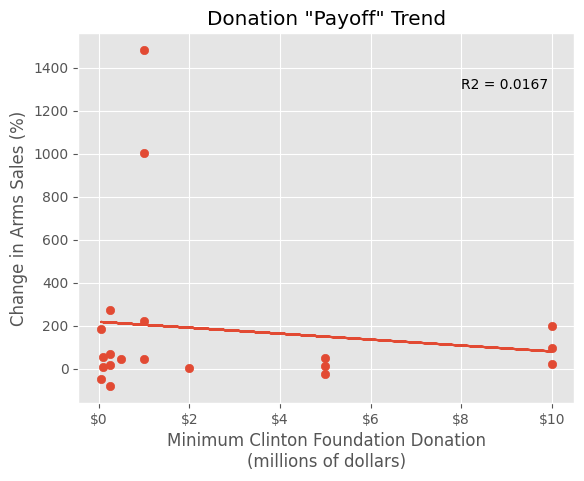

In [93]:
payoff_graph(curs)

In [134]:
changes = get_diffs(curs)

In [135]:
changes[:10]

[('BELGIUM', -7423445016),
 ('RUSSIA', -1398053937),
 ('SINGAPORE', -1192630458),
 ('SOUTH AFRICA', -844621573),
 ('IRAQ', -391956237),
 ('PORTUGAL', -326339598),
 ('ROMANIA', -312636281),
 ('SWEDEN', -138149029),
 ('TUNISIA', -137006281),
 ('GEORGIA', -103548252)]

In [136]:
changes[-10:]

[('ITALY', 4294875319),
 ('ISRAEL', 6023792517),
 ('AFGHANISTAN', 9195775907),
 ('TURKEY', 9621799948),
 ('UNITED KINGDOM', 11790625670),
 ('SOUTH KOREA', 15453115006),
 ('AUSTRALIA', 15923095306),
 ('UNITED ARAB EMIRATES', 22736952857),
 ('JAPAN', 54591368411),
 ('VARIOUS', 66514884492)]

In [78]:
len(changes)

99

In [52]:
changes[90:110]

[('MEXICO', 33.090347114883244),
 ('INDONESIA', 33.51695381748539),
 ('CZECH REPUBLIC', 38.16755469289638),
 ('POLAND', 38.96461540973573),
 ('JORDAN', 40.21590304020065),
 ('BRAZIL', 43.786157416899925),
 ('UNITED KINGDOM', 44.95896079467098),
 ('YEMEN', 45.239796911128416),
 ('TAIWAN', 45.898422094975444),
 ('NETHERLANDS', 51.68753937925291),
 ('ITALY', 53.82172799540152),
 ('SAINT LUCIA', 53.900693367189554),
 ('GUATEMALA', 53.9748622294),
 ('DOMINICA', 56.01305601622495),
 ('TURKS AND CAICOS ISLANDS', 56.35641606871985),
 ('BURUNDI', 58.159542125751585),
 ('DOMINICAN REPUBLIC', 61.82823256476232),
 ('NETHERLANDS ANTILLES', 62.707745090808466),
 ('MONTENEGRO', 64.32),
 ('ISRAEL', 68.71593478704175)]

In [138]:
sums = get_sums(curs)

In [54]:
len(sums)

2

In [139]:
sorted([(i[1], i[0]) for i in sums[0]])[-10:]

[(8030754085, 'AUSTRALIA'),
 (8258592316, 'SINGAPORE'),
 (8367684310, 'BELGIUM'),
 (8766223636, 'ISRAEL'),
 (9147637319, 'GERMANY'),
 (11446951739, 'SOUTH KOREA'),
 (20975621915, 'CANADA'),
 (26225307395, 'UNITED KINGDOM'),
 (37751799915, 'JAPAN'),
 (46150748206, 'VARIOUS')]

In [68]:
[i[1] for i in sums[1] if i[0]=='DJIBOUTI']

[1448317767]

In [130]:
sums_0608, sums_1012 = get_sums(curs)

# Match old and new value
changes = list()
cf_changes = list()
for earlier in sums_0608:
    for later in sums_1012:
        if earlier[0] == later[0]:
            if earlier[0] in [i[0] for i in CF_COUNTRIES]:
                cf_changes += [(earlier[0], earlier[1], later[1])]

In [131]:
cf_changes

[('ALGERIA', 649943709, 2431535005),
 ('AUSTRALIA', 8030754085, 23953849391),
 ('BAHRAIN', 219718802, 630586020),
 ('BRUNEI', 101239902, 19256846),
 ('CANADA', 20975621915, 24844128294),
 ('GERMANY', 9147637319, 9839619231),
 ('IRELAND', 144929678, 107064341),
 ('ITALY', 7979816849, 12274692168),
 ('JAMAICA', 18572209, 9639318),
 ('KUWAIT', 1895298212, 2109893611),
 ('MOROCCO', 250045824, 253096156),
 ('NETHERLANDS', 3069131994, 4655490802),
 ('NORWAY', 2718237833, 3351140380),
 ('OMAN', 170597237, 547003781),
 ('QATAR', 271325915, 4291824236),
 ('SAUDI ARABIA', 4105561815, 8094719012),
 ('TAIWAN', 2612251394, 3811233565),
 ('THAILAND', 656266680, 1113283489),
 ('UNITED ARAB EMIRATES', 2261801903, 24998754760),
 ('UNITED KINGDOM', 26225307395, 38015933065)]

In [128]:
CF_COUNTRIES

[('ALGERIA', 250000),
 ('AUSTRALIA', 10000000),
 ('BAHRAIN', 50000),
 ('BRUNEI', 250000),
 ('CANADA', 250000),
 ('GERMANY', 100000),
 ('IRELAND', 5000000),
 ('ITALY', 100000),
 ('JAMAICA', 50000),
 ('KUWAIT', 5000000),
 ('MOROCCO', 2000000),
 ('NETHERLANDS', 5000000),
 ('NORWAY', 10000000),
 ('OMAN', 1000000),
 ('QATAR', 1000000),
 ('SAUDI ARABIA', 10000000),
 ('TAIWAIN', 500000),
 ('THAILAND', 250000),
 ('UNITED ARAB EMIRATES', 1000000),
 ('UNITED KINGDOM', 1000000)]